In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm

import matplotlib as mpl

# Load data

In [8]:
vamps_summary = pd.read_hdf('./summaries/vamps_bs_summary.h5', key='vamps_summary')
ts_ratio_summary = pd.read_hdf('./summaries/ts_ratio_bs_summary.h5', key='ts_ratio_summary')
ts_summary = pd.read_hdf('./summaries/ts_bs_summary.h5', key='ts_summary')
hp_summary = pd.read_hdf('./summaries/hp_summary.h5', key='hp_summary')
m1_selection = pd.read_hdf('./summaries/m1_model_selection.h5')
m2_selection = pd.read_hdf('./summaries/m2_model_selection.h5')

chosen_lags = pd.read_hdf('chosen_lag_times.h5', key='chosen_lags')
chosen_dom_procs = pd.read_hdf('chosen_num_dominant.h5', key='chosen_num_dominant')

# Figure

In [13]:
df = vamps_summary.merge(ts_ratio_summary, on=['protein', 'hp_index', 'lag', 'num_its'], suffixes=['_vamp', '_gap'])
df = df.merge(hp_summary.loc[:, ['protein', 'hp_index', 'feature']], on=['protein', 'hp_index'])

In [37]:
m1_selection.sort_values(by=['protein', 'median'], ascending=False, inplace=True)
m2_selection.sort_values(by=['protein', 'median_vamp'], ascending=False, inplace=True)

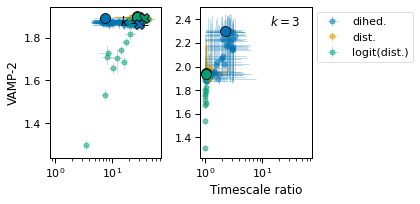

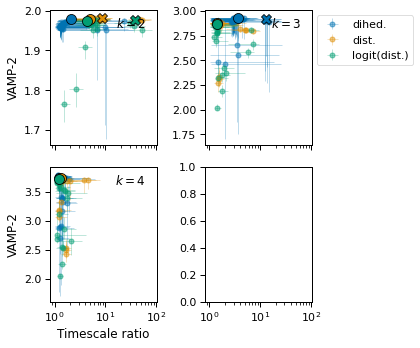

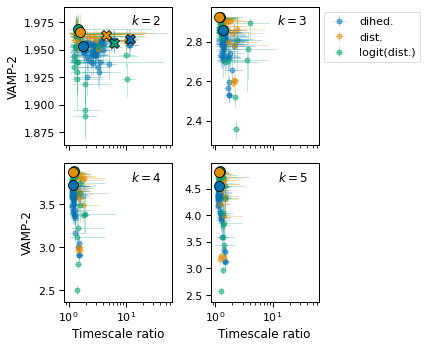

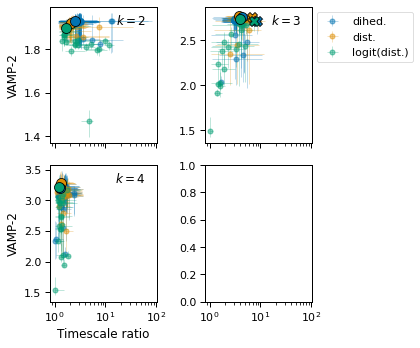

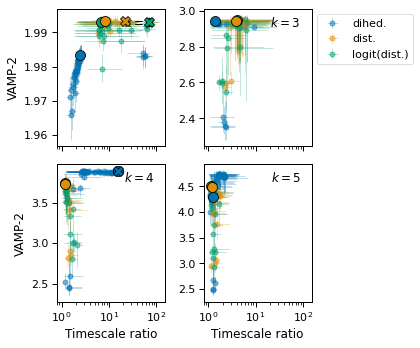

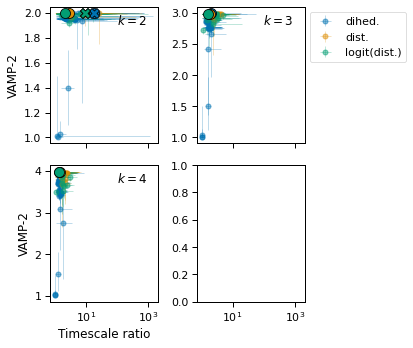

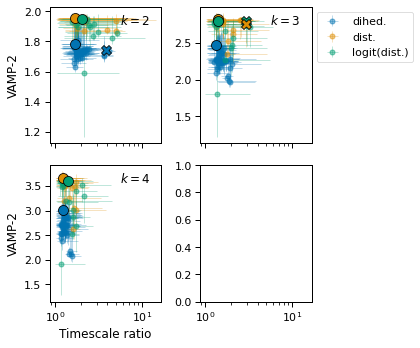

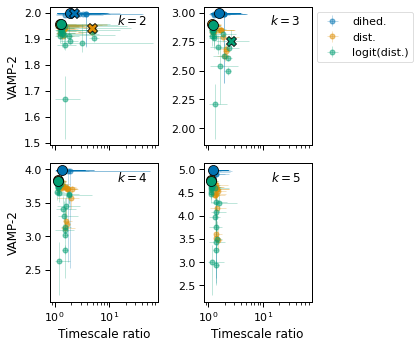

In [41]:
for protein in funcs.PROTEIN_LABELS[:5]+funcs.PROTEIN_LABELS[6:9]:

    max_k = chosen_dom_procs.loc[chosen_dom_procs.protein==protein, 'num_its'].values[0]+1
    lag = chosen_lags.loc[chosen_lags.protein==protein, 'lag'].values[0]

    ks = np.arange(2, max_k+1)
    n_ks = ks.shape[0]
    features = np.unique(df.feature.values)

    cols = sns.color_palette('colorblind', features.shape[0]+4)

    n_cols = 2
    n_rows = n_ks//n_cols + (n_ks % n_cols)

    with sns.plotting_context('paper', font_scale=1.25):

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 1+2*n_rows), sharey=False, sharex=True)
        if axes.ndim==1:
            axes = axes.reshape(1, -1)

        for i in range(ks.shape[0]):
            ax = axes.flatten()[i]

            for j, feat in enumerate(features):

                ix = (df.protein == protein) & (df.num_its == ks[i] ) & (df.lag == lag) & (df.feature == feat)
                x = df.loc[ix, 'median_gap'].values
                xerr = df.loc[ix, ['lb_diff_gap', 'ub_diff_gap']].values.T

                y = df.loc[ix, 'median_vamp'].values
                yerr = df.loc[ix, ['lb_diff_vamp', 'ub_diff_vamp']].values.T

                ax.errorbar(x, y, xerr=xerr, yerr=yerr, lw=0, elinewidth=0.5, marker='o', color=cols[j], alpha=0.5, label=feat, ms=5)
                ax.set_xscale('log')

            for mod_num in [0, 1, 2]:
                hp_ix = m1_selection.loc[m1_selection.protein==protein, 'hp_index'].values[mod_num]
                best_ix = (df.protein == protein) & (df.num_its == ks[i] ) & (df.lag == lag) & (df.hp_index == hp_ix)
                best_x = df.loc[best_ix, 'median_gap'].values
                best_y = df.loc[best_ix, 'median_vamp'].values     
                best_f = df.loc[best_ix, 'feature'].values[0]
                col_ix = np.where(features == best_f)[0][0]
                ax.scatter(best_x, best_y, marker='o', alpha=1, s=100, 
                           color=cols[col_ix], edgecolor='k', zorder=10)
    #             ax.annotate(text=f"{mod_num}", xy=(best_x, best_y))

                hp_ix = m2_selection.loc[m2_selection.protein==protein, 'hp_index'].values[mod_num]
                m2k = m2_selection.loc[m2_selection.protein==protein, 'num_its'].values[mod_num]
                if ks[i] == m2k:
                    best_ix = (df.protein == protein) & (df.num_its == ks[i] ) & (df.lag == lag) & (df.hp_index == hp_ix)
                    best_x = df.loc[best_ix, 'median_gap'].values
                    best_y = df.loc[best_ix, 'median_vamp'].values 
                    best_f = df.loc[best_ix, 'feature'].values[0]
                    col_ix = np.where(features == best_f)[0][0]

                    ax.scatter(best_x, best_y, marker='X', alpha=1, s=100, 
                               color=cols[col_ix], edgecolor='k', zorder=10)
    #             ax.annotate(text=f"{mod_num}", xy=(best_x, best_y))

            if i % n_cols == 0: 
                ax.set_ylabel(f'VAMP-2')

            if i // n_rows == 1: 
                ax.set_xlabel('Timescale ratio')

            ax.annotate(text=f"$k={{{ks[i]}}}$", xy=(0.9, 0.95), ha='right', va='top' , xycoords='axes fraction')


        axes[0, -1].legend(bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(Path(funcs.FIG_DIR).joinpath(f"vamp_vs_gap/{protein}_vamp_vs_gap.pdf"), bbox_inches='tight')
